![title](./cover.png)

# Misión
En esta práctica tendrás que descargar utilizando líneas de código formas de onda de la red IRIS y estimar la magnitud de ondas de superficie y de coda. 

# Parte 1- Magnitud de ondas de superficie
La magnitud de ondas de superficie se puede obtener a partir de conocer utilizando la siguiente ecuación (*ver pag. 264, Stein and Wysession. An introduction to seismology, earthquakes and earth structure.*).
$$
\begin{equation}
Ms=log_{10}A_{20}+1.66log\Delta+2.0
\end{equation}
$$<br><br>
Donde $A_{20}$ es la amplitud máxima de cero a pico en $\mu m$ de las ondas Rayleigh a 20s después de remover la resupuesta del intrumento, y $\Delta$ es la distancia en grados. <br>
En este ejercicio vamos a calcular la de ondas de superfie para el sismo del **19 de septiembre del 2017** en Puebla, Mexico. 
## Instrucciones
1. Carga las librerias.
2. Descarga los datos del sismos de la base de datos de IRIS. 
3. Descarga los datos de la estación <a href="https://www.fdsn.org/station_book/II/PFO/pfo.html">PFO, Piñon Flat, California</a>.
4. Remueve la repuesta al instrumento.
5. Calcula la distancia en grados al sismo. 
6. Mide la media de la amplitud máxima de las 3 componente. 
7. Aplica la ecuación para calcular la magitud. 

In [10]:
# Importa las librerias
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth
from obspy.core import read
from obspy.signal.filter import envelope
from matplotlib import pyplot as plt
import numpy as np
import math
%matplotlib inline

In [3]:
# Busca todos los sismos de magnitud mayor a 7 de la base de datos de IRIS y extrae el tiempo y localización. 
t1 = UTCDateTime("2017-09-19T00:00:00.0")
t2 = UTCDateTime("2017-09-20T00:00:00.0")
fdsn_client = Client('IRIS')

cat    = fdsn_client.get_events(starttime=t1, endtime=t2, minmagnitude=7)
time   = cat[0].origins[0].time
lat_eq = cat[0].origins[0].latitude
lon_eq = cat[0].origins[0].longitude
dep_eq = cat[0].origins[0].depth
print(cat)

1 Event(s) in Catalog:
2017-09-19T18:14:38.430000Z | +18.568,  -98.481 | 7.1 Mww


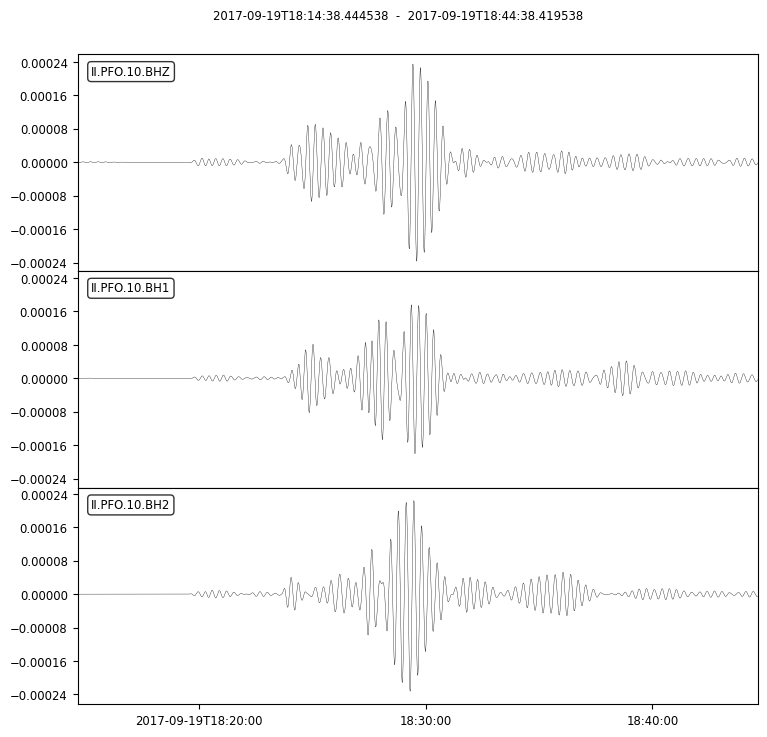

In [4]:
# Descarga los datos de la página de IRIS
# Nota. Los datos se guardan en la variable st, no se guardan en un archivo lo cual lo puedes hacer 
# si lo deseas con el comando st.write()
st = fdsn_client.get_waveforms(network='II', station='PFO', location='10',
                               channel='BH1,BH2,BHZ', starttime=time, endtime=time + 30*60,
                               attach_response=True)
st.detrend()
inv = fdsn_client.get_stations(network='II', station='PFO', location='10',
                                channel='*', level='station')


pre_filt = (0.001, 0.002, 40.0, 50.0)
st.remove_response(output='DISP')
st.filter('bandpass', freqmin=1./22, freqmax=1./18, corners=2)
st.plot(linewidth=0.25);

In [5]:
# Calcula la distancia de la estación al sismo
net     = inv[0]
station = net[0]
print("station: ", station)
Delta, _, _  = gps2dist_azimuth(station.latitude, station.longitude, lat_eq, lon_eq)
Delta       /= 111.11e3
print('Delta: ', Delta)

station:  Station PFO (Pinon Flat, California, USA)
	Station Code: PFO
	Channel Count: 0/283 (Selected/Total)
	1986-10-24T00:00:00.000000Z - 2006-07-12T23:59:59.000000Z
	Access: open 
	Latitude: 33.61, Longitude: -116.46, Elevation: 1280.0 m
	Available Channels:

Delta:  21.996939503796227


In [6]:
# Calcula A20 en micrometros como la media de la amplitud máxima de las 3 componentes
max_amp = list()
for tr in st:
    max_amp.append(np.abs(tr.data).max()*1e6)
A20 = np.median(np.array(max_amp))

In [8]:
# Calcula la magnitud
Ms = np.log10(A20) + 1.66*np.log10(Delta) + 2
print('Ms = ', Ms)

Ms =  6.594260806


# Parte 2 - Magnitud de duración Mc
Otra forma de medir la magnitud de un sismos que es particularmente útil para sismos de baja magnitud es la magnitud de duración. El SSN la define de la siguiente manera (ver http://publications.isc.ac.uk/index.php/summary/article/view/31).<br><br>
$$
\begin{equation}
Mc    = 0.09 + 1.85*log_{10}(T) + 0.0004*d
\end{equation}
$$<br>
Donde $T$ es la duración del sismo, desde la llegada de la **onda P** hasta el tiempo que le toma a la señal regresar al nivel de ruido previo y $d$ es la distancia en km. En esta sección vamos a calcular la magnitud de coda para 4 sismos de magnitud M={3.1, 3.5, 4.0, 5.2) localizados en la misma área a aproximadamente 100 km de la estación YOIG. 
# Instrucciones
1. Define una variable con la llegada de la onda P en segundos y la distancia epicentral. 
2. Escribe una función para el cálculo de la envolvente. Debe de regresar el valor máximo de la señal para un ventana de tiempo de 1s. 
3. Escribe una función para el cálculo de la magnitud de coda. 
4. Lee los datos.
5. Aplica un filtro paso altas a 1Hz. 
6. Calcula la envolvente y la coda y grafíca tus resultados. 

In [11]:
# Paso 1
tp   = 15 
dist = 100

In [12]:
# Paso 2
def envelope(x, fs):
    Nbatch = int(len(x)/fs)
    out  = np.zeros((Nbatch,1))
    tout = np.zeros_like(out) 
    for k in range(Nbatch):
        out[k]  = np.amax(x[k*int(fs):(k+1)*int(fs)],axis=0)
        tout[k] = k + 0.5
        
    return (tout, out)

In [13]:
# Paso 3
def coda_mag(tenv, env, dist, tp):
    noise = env[0]
    tind  = np.where(env <= noise)
    taux  = tenv[tind]
    td    = np.where(taux > tp)
    tcoda = taux[td[0][0]]
    T     = tcoda - tp
    Mc    = 0.09 + 1.85*np.log10(T) + 0.0004*dist
    print('Mc: ', Mc)
    
    return (tcoda, Mc)

Mc:  4.40084416509
Mc:  3.78454884574
Mc:  3.02024179924
Mc:  1.49967097556


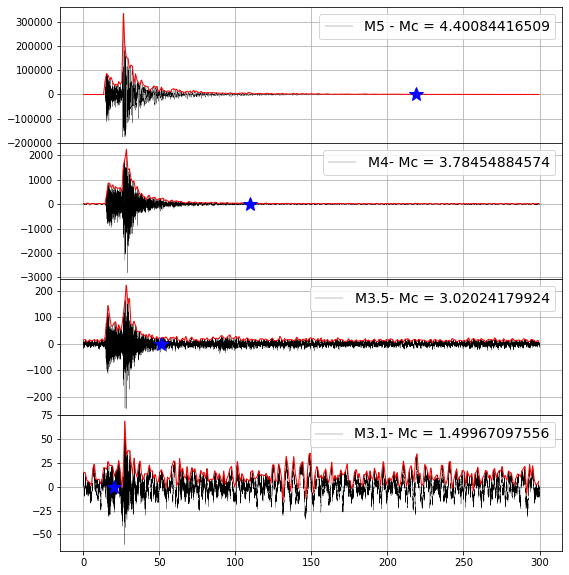

In [14]:
M5   = read('20200124104749.IG.YOIG.HHZ.sac')
M4   = read('20201005024525.IG.YOIG.HHZ.sac')
M35  = read('20200720151919.IG.YOIG.HHZ.sac')
M31  = read('20170502034042.IG.YOIG.HHZ.sac')

M5.detrend()
M4.detrend()
M35.detrend()
M31.detrend()

M5.filter('highpass',freq=1, corners=2)
M4.filter('highpass',freq=1, corners=2)
M35.filter('highpass',freq=1, corners=2)
M31.filter('highpass',freq=1, corners=2)

data_M5      = M5[0].data
T            = M5[0].stats.delta
fs           = 1.0/T

time         = M5[0].times()
tenv, env_M5 = envelope(data_M5, fs)
td5, Mc5     = coda_mag(tenv, env_M5, dist, tp)

data_M4      = M4[0].data
T            = M4[0].stats.delta
fs           = 1.0/T
tenv, env_M4 = envelope(data_M4, fs)
td4, Mc4     = coda_mag(tenv, env_M4, dist, tp)

data_M35 = M35[0].data
T        = M35[0].stats.delta
fs       = 1.0/T
tenv, env_M35 = envelope(data_M35, fs)
td35, Mc35     = coda_mag(tenv, env_M35, dist, tp)

data_M31 = M31[0].data
T        = M31[0].stats.delta
fs       = 1.0/T

tenv, env_M31  = envelope(data_M31, fs)
td31, Mc31     = coda_mag(tenv, env_M31, dist, tp)

# Graficación
fig1, axs = plt.subplots(4, 1, sharex=True, figsize=(9,10))
fig1.subplots_adjust(hspace=0)
axs[0].plot(time, M5[0].data, lw=0.25, color='k',  label='M5 ' + '- Mc = ' + str(Mc5))
axs[0].plot(tenv, env_M5,lw=1, color='r')
axs[0].plot(td5, 0, 'b*',markersize=14)
axs[0].grid(True)
axs[0].legend(fontsize=14)

axs[1].plot(time, M4[0].data, lw=0.25, color='k',  label='M4' + '- Mc = ' + str(Mc4))
axs[1].plot(tenv, env_M4,lw=1, color='r')
axs[1].plot(td4, 0, 'b*',markersize=14)
axs[1].grid(True)
axs[1].legend(fontsize=14)

axs[2].plot(time, M35[0].data, lw=0.25, color='k', label='M3.5' + '- Mc = ' + str(Mc35))
axs[2].plot(tenv, env_M35,lw=1, color='r')
axs[2].plot(td35, 0, 'b*',markersize=14)
axs[2].grid(True)
axs[2].legend(fontsize=14)

axs[3].plot(time, M31[0].data, lw=0.25, color='k', label='M3.1' + '- Mc = ' + str(Mc31))
axs[3].plot(tenv, env_M31,lw=1, color='r')
axs[3].plot(td31, 0, 'b*',markersize=14)
axs[3].grid(True)
axs[3].legend(fontsize=14)

# Parte 3 - Cálculo de los espectros
Por último vamos a calcular los espectros de tal forma que podamos compara las amplitudes de los espectros producidos por sismos de diferente magnitudes. Para ello vamos a realizar la transformada discreta de Fourier implementada en **numpy** a través de la función <a href="https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft">numpy.fft.fft</a>. 
## Instrucciones.
1. Implementa la función FForier, la cual deberá de calcular la transformada de Fourier y regresar un vector de frecuencias desde 0 hasta la frecuencia de Nyquist. Ten en cuenta que la transformda de Fourier es simétrica, solo es necesario que la función regrese la mitad del espectro.
2. Grafíca tus resultados. 

In [17]:
def FFourier(x, Fs):
    L       = len(x)
    NFFT    = 2**math.ceil(math.log(L,2)) # Siguiente potencia de 2
    XF      = np.fft.fft(x,NFFT)/NFFT

    freq    = Fs/2*np.linspace(0,1,num=int(NFFT/2+1), endpoint=True)
    XF      = XF[0:int(NFFT/2+1)]
    return (freq, XF)

In [18]:
freq, M5F      = FFourier(data_M5, fs)
freq, M4F      = FFourier(data_M4, fs)
freq, M35F     = FFourier(data_M35, fs)
freq, M31F     = FFourier(data_M31, fs)

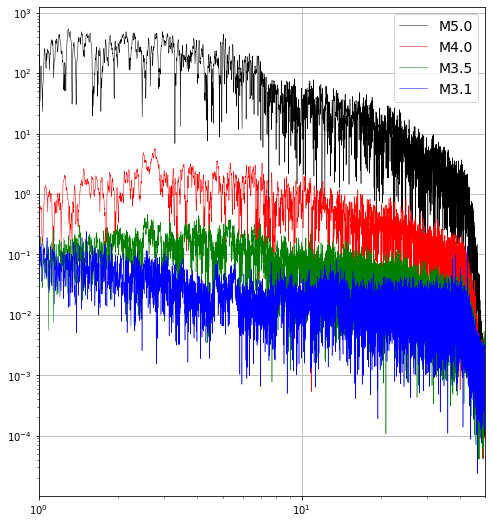

In [20]:
fig2 = plt.figure(figsize=(8,9))
ax = fig2.add_subplot()
ax.loglog(freq, np.abs(M5F),lw = 0.5, color='k', label='M5.0')
ax.loglog(freq, np.abs(M4F),lw = 0.5, color='r', label='M4.0')
ax.loglog(freq, np.abs(M35F),lw = 0.5, color='g', label='M3.5')
ax.loglog(freq, np.abs(M31F),lw = 0.5, color='b', label='M3.1')
ax.legend(fontsize=14)
ax.grid()
ax.set_xlim(1, 50)
plt.show()